# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [3]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [5]:
sim.summary(sig_figs=5)


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.000,NaN,0.000,0.00000,0.0000,0.000,NaN,NaN,NaN
mu,177.860,0.62677,20.248,144.88000,177.7300,211.260,1043.60,115960.0,0.99964
sigma,14.676,0.47586,14.721,0.74459,9.6513,43.871,956.98,106330.0,0.99904
height,178.950,0.99052,30.599,132.32000,178.6000,225.650,954.34,106040.0,0.99900


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [6]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [7]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


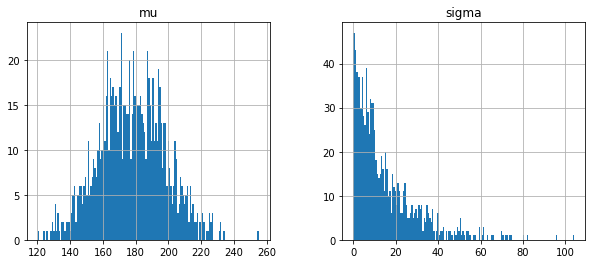

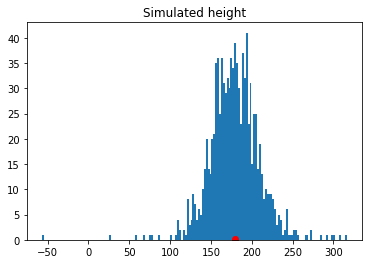

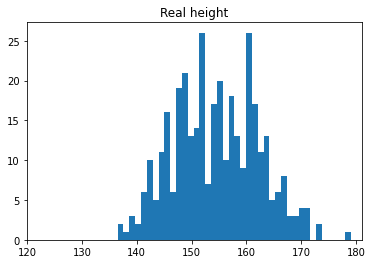

In [8]:
sim.draws_pd().hist(column=['mu', 'sigma'], bins=160, figsize=(10, 4))
plt.show()

plt.hist(sim.draws_pd().height, bins=160)
plt.scatter(np.mean(sim.draws_pd().height), 0.2, c='r')
plt.title('Simulated height')
plt.show()
plt.hist(d.height, bins=40)
plt.title('Real height')
plt.xlim(120, 181)
plt.show()

##### Conclusion

Oserved data cant be obtained from priors


In [9]:
sim.draws_pd()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,232.163,8.126140,217.968
1,0.0,0.0,188.640,70.331700,297.765
2,0.0,0.0,170.755,11.778900,178.482
3,0.0,0.0,182.602,19.518000,217.971
4,0.0,0.0,152.394,4.678490,159.762
...,...,...,...,...,...
995,0.0,0.0,178.704,0.038448,178.692
996,0.0,0.0,172.086,5.345250,171.941
997,0.0,0.0,188.423,12.742400,183.248
998,0.0,0.0,154.132,4.810070,151.071


In [10]:
#Convertion to arviz InferenceData
arviz_result = az.from_cmdstanpy(
    posterior=sim,
)
arviz_result


Inference data with groups:
	> posterior
	> sample_stats

d:\Users\barte\Anaconda3\envs\data_analytics\lib\site-packages\arviz\plots\pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


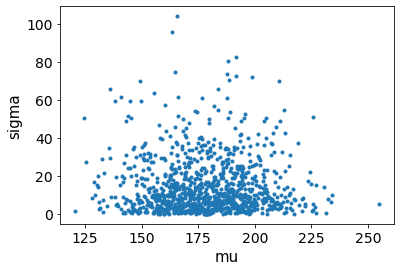

In [11]:
az.plot_pair(arviz_result, var_names=['mu', 'sigma'], divergences=True)
plt.show()

#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



In [12]:
arviz_result_2 = az.from_cmdstanpy(
    posterior=fit,
)
arviz_result_2

Inference data with groups:
	> posterior
	> sample_stats

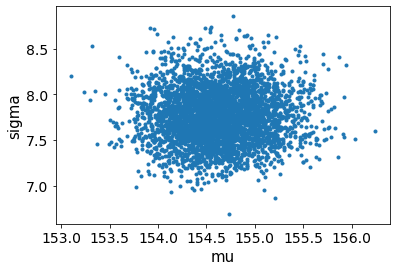

In [13]:
az.plot_pair(arviz_result_2, var_names=['mu', 'sigma'], divergences=True)
plt.show()

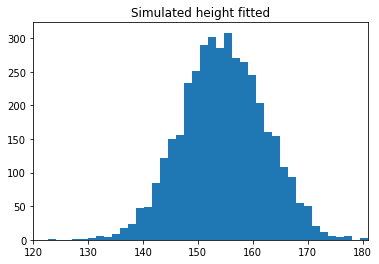

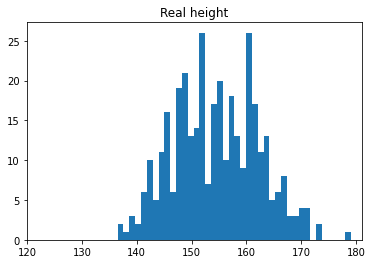

In [14]:
plt.hist(fit.draws_pd().height, bins=40)
plt.xlim(120, 181)
plt.title('Simulated height fitted')
plt.show()

plt.hist(d.height, bins=40)
plt.xlim(120, 181)
plt.title('Real height')
plt.show()

##### Conclusion

This model to some extend simulate our model, but the shape of both histograms are a little bit different

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [53]:
d['c_weight'] = (d.weight - np.mean(d.weight))
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


In [54]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), 50)}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

sim.draws_pd().head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,232.163,7.771810,23.208300,126.945,96.8011,139.8230,166.9940,196.8110,...,353.4910,375.26600,372.3590,347.7260,314.6710,339.3220,350.56700,379.6720,373.6310,387.0100
1,0.0,0.0,154.022,-0.067795,0.086958,155.071,154.9870,154.9410,154.9350,154.8940,...,153.4310,153.15200,153.0320,153.0520,152.9390,153.0230,152.84300,152.8810,152.9590,152.7940
2,0.0,0.0,169.461,-11.386400,20.358900,356.791,316.7030,309.8530,318.0190,306.3020,...,66.8444,-3.16095,47.2156,15.8324,41.4377,-5.6454,6.99248,-11.5414,-28.9123,-31.1721
3,0.0,0.0,158.357,-2.544520,6.415610,202.302,187.8850,189.0630,182.6860,185.7290,...,131.0530,126.80500,126.6680,131.7030,118.0180,116.1060,123.25000,112.7940,116.8110,110.2640
4,0.0,0.0,158.131,16.710200,9.955320,-100.451,-69.4664,-60.4966,-49.5101,-18.0338,...,376.6260,384.91100,375.4720,395.4100,403.1500,410.9170,421.00300,444.7230,453.7910,450.8480


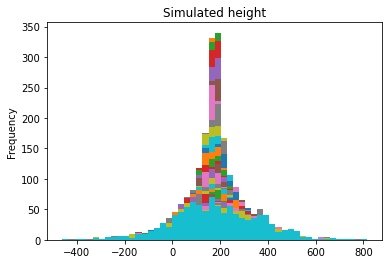

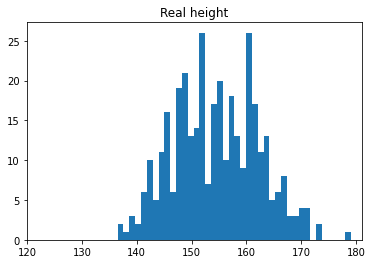

In [17]:
y_prior = sim.draws_pd().loc[:, 'height[1]':]

y_prior.plot(kind='hist', bins=50, legend=False)
# plt.hist(sim.draws_pd().loc[:, 'height[1]':'height[50]'], bins=40, color=['tab:blue']*50)
# plt.xlim(120, 181)
plt.title('Simulated height')
plt.show()

plt.hist(d.height, bins=40)
plt.xlim(120, 181)
plt.title('Real height')
plt.show()

### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

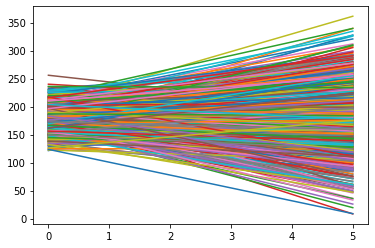

In [55]:
plt.figure()

for i in range(len(sim.draws_pd())):
    x = np.linspace(0,5,100)
    y = sim.draws_pd()['beta'][i]*x+sim.draws_pd()['alpha'][i]
    plt.plot(x, y,)

plt.show()

#### Conclusion
Theoreticly if weight of preson is very high then his height would be large, but in reality at some point height is "limited" by nature (Wikipedia says that limit is about 2m, but we can observe single examples of higher people)
If b and a get specific value we can obtain negative height.

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [56]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [57]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


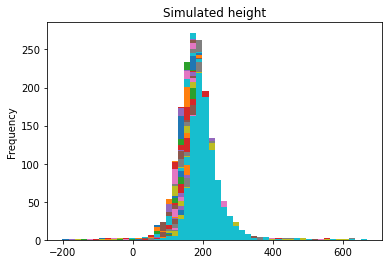

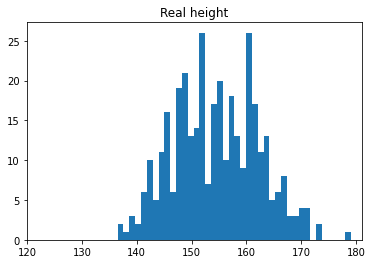

In [21]:
y_prior = sim.draws_pd().loc[:, 'height[1]':]

y_prior.plot(kind='hist', bins=50, legend=False)

# plt.hist(sim.draws_pd().loc[:, 'height[1]':'height[50]'], bins=40, color=['tab:blue']*50)
# plt.xlim(0, 400)
plt.title('Simulated height')
plt.show()

plt.hist(d.height, bins=40)
plt.xlim(120, 181)
plt.title('Real height')
plt.show()

#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

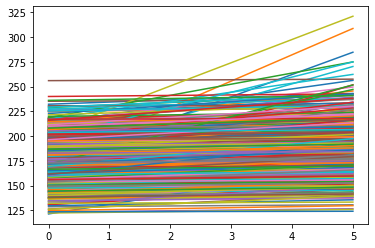

In [58]:
plt.figure()

for i in range(len(sim.draws_pd())):
    x = np.linspace(0,5,100)
    y = sim.draws_pd()['beta'][i]*x+sim.draws_pd()['alpha'][i]
    plt.plot(x, y,)

plt.show()

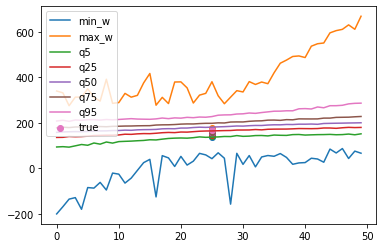

In [60]:
plt.figure()

min_w = []
max_w = []
q5 = []
q25 = []
q50 = []
q75 = []
q95 = []

hei = sim.draws_pd().loc[:, 'height[1]':]

for i in hei:
    min_w.append(min(hei[i]))
    max_w.append(max(hei[i]))
    q5.append(hei[i].quantile(.05))
    q25.append(hei[i].quantile(.25))
    q50.append(hei[i].quantile(.50))
    q75.append(hei[i].quantile(.75))
    q95.append(hei[i].quantile(.95))

plt.plot(min_w, label='min_w')
plt.plot(max_w, label='max_w')
plt.plot(q5, label='q5')
plt.plot(q25, label='q25')
plt.plot(q50, label='q50')
plt.plot(q75, label='q75')
plt.plot(q95, label='q95')

min_t = min(d.height)
max_t = max(d.height)
q5_t = d.height.quantile(.05)
q25_t = d.height.quantile(.25)
q50_t = d.height.quantile(.50)
q75_t = d.height.quantile(.75)
q95_t = d.height.quantile(.95)

plt.scatter(25, min_t)
plt.scatter(25, max_t)
plt.scatter(25, q5_t)
plt.scatter(25, q25_t)
plt.scatter(25, q50_t)
plt.scatter(25, q75_t)
plt.scatter(25, q95_t, label="true")

plt.legend()
plt.show()

#### Conclusion 
Real data can be obtained within prior

### Fitting data


In [61]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [62]:
data_fit = dict(N=len(d.weight), weight=d.weight, heights=d.height)
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)






chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:05 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |


INFO:cmdstanpy:CmdStan done processing.


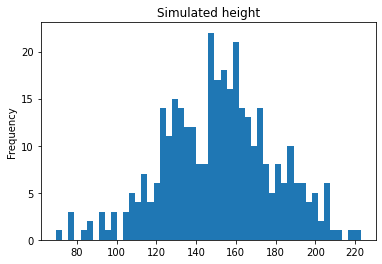

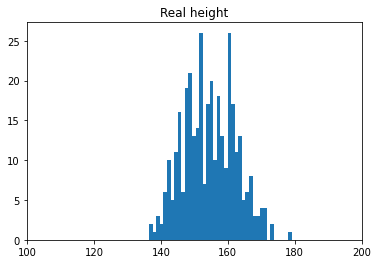

In [63]:
y_prior = fit.draws_pd().loc[5, 'height[1]':]

y_prior.plot(kind='hist', bins=50, legend=False)

# plt.hist(fit.draws_pd().loc[:, 'height[1]':'height[50]'], bins=20, color=['tab:blue']*50)
# plt.xlim(100, 200)
plt.title('Simulated height')
plt.show()

plt.hist(d.height, bins=40)
plt.xlim(100, 200)
plt.title('Real height')
plt.show()

#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


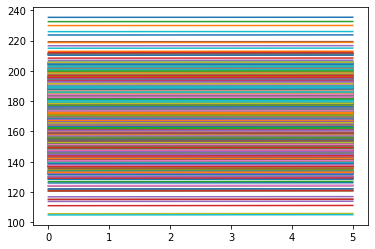

In [70]:
# print(fit.draws_pd())

plt.figure()

for i in range(1000):
    x = np.linspace(0,5,100)
    y = fit.draws_pd()['beta'][i]*x+fit.draws_pd()['alpha'][i]

    plt.plot(x, y)

plt.show()

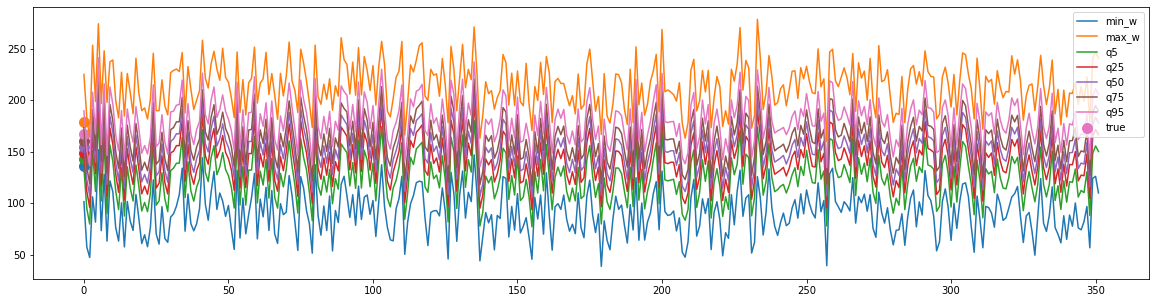

In [80]:
plt.figure(figsize=(20, 5))

min_w = []
max_w = []
q5 = []
q25 = []
q50 = []
q75 = []
q95 = []

hei = fit.draws_pd().loc[:, 'height[1]':]

for i in hei:
    min_w.append(min(hei[i]))
    max_w.append(max(hei[i]))
    q5.append(hei[i].quantile(.05))
    q25.append(hei[i].quantile(.25))
    q50.append(hei[i].quantile(.50))
    q75.append(hei[i].quantile(.75))
    q95.append(hei[i].quantile(.95))

plt.plot(min_w, label='min_w')
plt.plot(max_w, label='max_w')
plt.plot(q5, label='q5')
plt.plot(q25, label='q25')
plt.plot(q50, label='q50')
plt.plot(q75, label='q75')
plt.plot(q95, label='q95')

min_t = min(d.height)
max_t = max(d.height)
q5_t = d.height.quantile(.05)
q25_t = d.height.quantile(.25)
q50_t = d.height.quantile(.50)
q75_t = d.height.quantile(.75)
q95_t = d.height.quantile(.95)

plt.scatter(0, min_t, s=100)
plt.scatter(0, max_t, s=100)
plt.scatter(0, q5_t, s=100)
plt.scatter(0, q25_t, s=100)
plt.scatter(0, q50_t, s=100)
plt.scatter(0, q75_t, s=100)
plt.scatter(0, q95_t, label="true", s=100)

plt.legend()
plt.show()

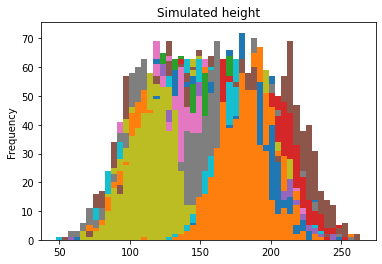

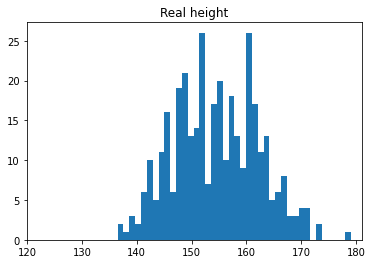

In [82]:
y_prior = fit.draws_pd().loc[:500, 'height[1]':]

y_prior.plot(kind='hist', bins=50, legend=False)

# plt.hist(sim.draws_pd().loc[:, 'height[1]':'height[50]'], bins=40, color=['tab:blue']*50)
# plt.xlim(0, 400)
plt.title('Simulated height')
plt.show()

plt.hist(d.height, bins=40)
plt.xlim(120, 181)
plt.title('Real height')
plt.show()

#### Conclusion
Observed data can be obtained within our model. Additionaly simulated values metrics are closer to real data than in prior model.
Increasing N increase uncertainity